Дослідження роботи алгоритмА Флойда-Воршала, а також порівняння реалізації з вбудованим :

Мета : 

1. Дослідити ефективність нашої реалізації алгоритма на графах різного розміру (10, 20, 50, 100, 200, 500 вершин)

2. Дослідити роботу алгоритма за наявності ребер від'ємної довжини.

3. Порівняти ефективність роботу реалізованого алгоритма з вбудованим.


In [47]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from time import time

In [2]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

In [3]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G


Нижче представлено нашу реалізацію алгоритма Флойда-Воршалла, який шукає найкоротші відстані між усіма
парами вершин у графі та записує результат у словник у форматі 
{node0: {node0:weight0, node1:weight1, ...}, ...}
Функція, приймає єдиний параметр - G ( граф згенерований ф-єю gnp_random_connected_graph(), чи будь-який інший граф створений за допомогою бібліотеки networkx ) 

In [49]:
def floyd_warshall_algorithm(G : dict) -> dict:
    n = len(G.nodes())
    inf = float("inf")
    # Create a standart matrix of distances n*n each element of which is infinity
    matrix = {_:{_: inf for _ in range(n)} for _ in range(n)}
    # Create a starting matrix, assign to all pairs of [i, i] (exm. (0,0)) a distance of 0
    # If there is a path between two nodes, assign the weight of the edge between them to the corresponding
    # element of the matrix
    for i in range(n):
        matrix[i][i] = 0
        for j in range(n):
            if (i,j) in G.edges():
                matrix[i][j] = G.get_edge_data(i,j)['weight']
    # for n iterations choose the minimum between matrix[i][j], matrix[i][k]+matrix[k][j]
    # which means that you look through the whole matrix, element by element for n times and compare
    # the element you're currently in and the sum of the element in the current row and collumn is current iteration
    # + the element of the current collumn with the row of current iteration. 
    for k in range(n):
        for i in range(n):
            for j in range(n):
                matrix[i][j] = min(matrix[i][j], matrix[i][k]+matrix[k][j])
    return matrix


In [ ]:
Перевірмо коректність роботи нашого алгоритму, порівнявши результати вбудованої та нашої функцій.
Наступний код виведе результати роботи алгоритмів та в кінці порівняє два словники.
(Спершу для неорієнтованого графа, потім для орієнтованого)

In [ ]:
# generate a graph, run two functions (our and imbeded algorithm, and check if they give equal results), undirected graph
G = gnp_random_connected_graph(10, 0.5, False)
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    matrix = floyd_warshall_algorithm(G)
    print("Imbeded algorithm")
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
    print("Our algorithm")
    for k, v in matrix.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")
print(matrix == dist)

In [ ]:
# generate a graph, run two functions (our and imbeded algorithm, and check if they give equal results), directed graph
G = gnp_random_connected_graph(10, 0.5, True)
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    matrix = floyd_warshall_algorithm(G)
    print("Imbeded algorithm")
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
    print("Our algorithm")
    for k, v in matrix.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")
print(matrix == dist)

Запустивши два попередні тести, побачимо, що вони видають позитивний результат.

Тепер перевіримо ефективність нашого та вбудованого алгоритмів в залежності від кількості вершин у графі
та його заповненості.

In [96]:
# create a list of num of nodes and completeness for which you wanna check how the function works
#set the number of iterations you want to run the functions
num_of_nodes = [10, 20, 50, 100]
edge_probability = [0.1, 0.4, 0.6, 0.9]
NUM_OF_ITERATIONS = 100
our_probability_depended_time = []
imbeded_probability_depended_time = []

# for each probability you're checking, check time for diffent number of nodes
for probab in edge_probability:
    our_total_time = []
    imbeded_total_time = []
    for num in num_of_nodes:
        #this cycle checks time for different num of nodes
        our_time_taken = 0
        imbeded_time_taken = 0

        for i in range(NUM_OF_ITERATIONS):
            # this cycle just runs the following functions for a lot(1000) times, to check the average time
            # to be fair with both functions each iterration they're given the same graph(though graphs change with each iterration)
            G = gnp_random_connected_graph(num, i, False)
            start = time()
            floyd_warshall_algorithm(G)
            end = time()
            our_time_taken += end - start
            start = time()
            floyd_warshall_predecessor_and_distance(G)
            end = time()
            imbeded_time_taken += end - start
        # this stores time for all different nodes in a list each iteration
        our_total_time.append(our_time_taken/NUM_OF_ITERATIONS)
        imbeded_total_time.append(imbeded_time_taken/NUM_OF_ITERATIONS)
    # the next two lists are matrixes,
    # where each element is a vector,consisting of time records for each num of nodes,
    # each vector corresponds to the completeness level
    our_probability_depended_time.append(our_total_time)
    imbeded_probability_depended_time.append(imbeded_total_time)
#print(our_probability_depended_time)
#print(imbeded_probability_depended_time)

0.1
10
20
50
100
0.4
10
20
50
100
0.6
10
20
50
100
0.9
10
20
50
100


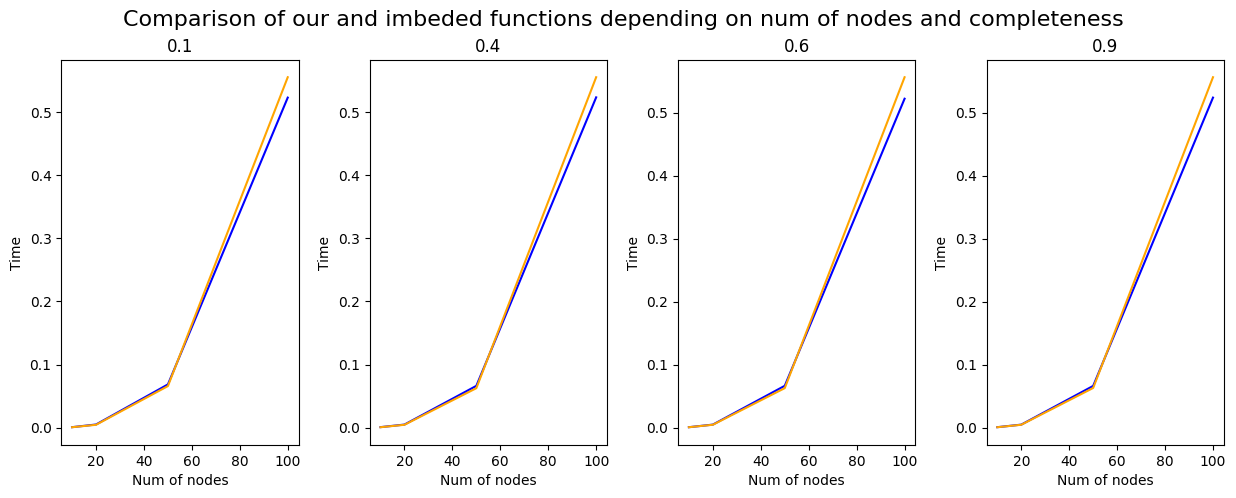

In [97]:
fig, ax1 = plt.subplots(1, 4, sharex=True, figsize=(15, 5))
# Plot the data on each subplot
fig.suptitle('Comparison of our and imbeded functions depending on num of nodes and completeness', fontsize=16)
for i in range(4):
    ax1[i].plot(num_of_nodes, our_probability_depended_time[i], color = "blue", label = "Our taken time")
    ax1[i].plot(num_of_nodes, imbeded_probability_depended_time[i], color = "orange", label = "Imbeded time taken")
    ax1[i].set_title(edge_probability[i])
for ax in ax1.flat:
    ax.set(ylabel='Time', xlabel='Num of nodes')
plt.subplots_adjust(wspace=0.3)
plt.show()

Висновок:
Як ми можемо помітити, середній час роботи нашого алгоритма приблизно однаковий з середнім часом роботи вбудованого, але трошки швидший з більшою кількість вершин. Причиною цієї похибки може бути те, що наш алгоритм реалізовує лише пошук найкоротших відстаней між парами вершин, тим часом як вбудований алгоритм надає доступ до інформацію про попередню вершину, яку треба пройти або відстань до між заданими парами вершин була найкоротшою, що дозволяє користувачеві прослідкувати шлях, який треба пройти для отримання найкоротшої відстані.